In [168]:
import itertools as it
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc_file('../repos/lhcb-matplotlibrc/matplotlibrc')

In [169]:
bin_sets = (-1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000)
magnets = ("both_directions",)
shapes = ("OldCruijff", "OldExtCruijff", "NewCruijff", "NewExtCruijff")
trials = range(5)
years = ("2015", "2018", "run2")

def check_file(path):
    with open(path, "r") as infile:
        for line in infile:
                
            if "sigma" in line and abs(float(line.split("=",1)[1].split("+/-",1)[0])) < 5.1:
                return False
            if "beta" in line and abs(float(line.split("=",1)[1].split("+/-",1)[0])) > 0.000999:
                return False
            if "Covariance quality" in line and ": 3" not in line:
                return False
            if "Minuit status" in line and ": 0" not in line:
                return False
    return True


 
def get_rchi2(path):
    with open(path, "r") as infile:
        for line in infile:
            if "Reduced chi^2:" in line:
                return line.strip().split(":", 1)[1].split("+/-")
    return np.inf

def get_time(path):
    with open(path, "r") as infile:
        for line in infile:
            if "Time elapsed:" in line:
                return float(line.strip().split(":", 1)[1].replace("s", ""))
    return np.inf

dfs = []
for n, (bins, magnet, shape, trial, year) in enumerate(it.product(bin_sets, magnets, shapes, trials, years)):
    path = f"/home/jgooding/LHCb/B2OC/Asfs/asfs-benchmarking/fitting/results/MC/Bs2DsPi/{year}/{magnet}/{shape}/MC_Bs2DsPi_Ds2KKpi_{year}_{magnet}_fit_result_{shape}_{bins}bins_trial{trial}.txt"

    if check_file(path):
        rchi2, rchi2_error = get_rchi2(path)
        dfs += [
            pd.DataFrame.from_dict(
                {str(n): [int(bins), magnet, shape, trial, year, float(rchi2), float(rchi2_error), get_time(path)]},
                orient="index",
                columns=["bins", "magnet", "shape", "trial", "year", "rchi2", "rchi2_err", "time"]
            )
        ]
total_df = pd.concat(dfs)

In [170]:
old_cruijff_df = total_df[total_df["shape"] == "OldCruijff"]
old_ext_cruijff_df = total_df[total_df["shape"] == "OldExtCruijff"]
new_cruijff_df = total_df[total_df["shape"] == "NewCruijff"]
new_ext_cruijff_df = total_df[total_df["shape"] == "NewExtCruijff"]

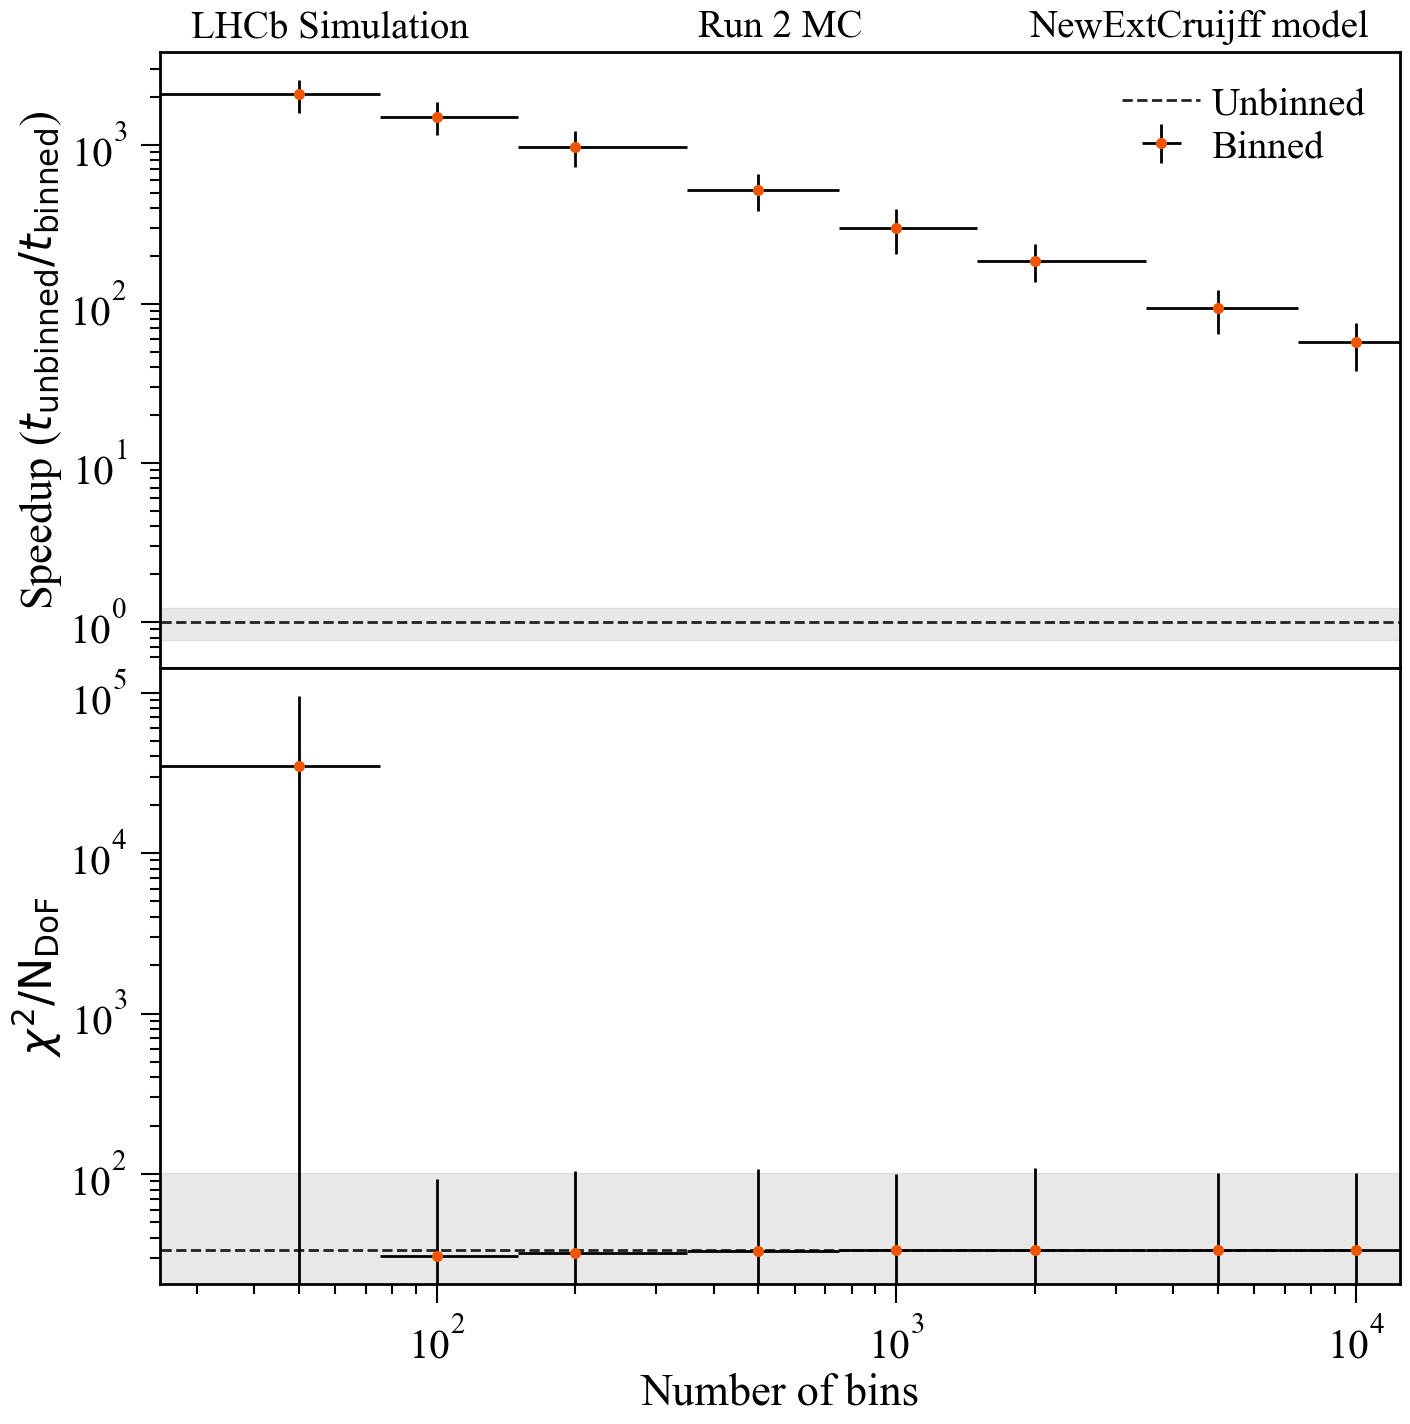

In [208]:
for shape in ("NewExtCruijff",):#shapes:
    shape_df = total_df[total_df["shape"] == shape]
    for year in ("run2",):#years:
        year_df = shape_df[shape_df["year"] == year]
        
        times = []
        time_errs = []
        rchi2s = []
        rchi2_errs = []
        plot_bins = []
        for bins in bin_sets:
            df = year_df[year_df["bins"] == bins]
            if len(df) > 0:
                plot_bins += [bins,]
                times += [np.mean(df["time"]),]
                time_errs += [np.std(df["time"]),]
                rchi2s += [np.average(df["rchi2"], weights=df["rchi2_err"]**-2),]
                rchi2_errs += [np.sqrt(np.sum(df["rchi2_err"]**2)),]
        plot_bins = np.array(plot_bins)
        times = np.array(times)
        time_errs = np.array(time_errs)
        rchi2s = np.array(rchi2s)
        rchi2_errs = np.array(rchi2_errs)
        #plt.errorbar(bin_sets[1:], times[1:], time_errs[1:])
        #plt.plot([0, max(bin_sets)], [times[0], times[0]])
        #plt.yscale("log")
        #plt.show()
        
        #plt.errorbar(bin_sets[1:], rchi2s[1:], yerr=rchi2_errs[1:])
        #plt.plot([0, max(bin_sets)], [rchi2s[0], rchi2s[0]])
        #plt.yscale("log")
        #plt.show()
        
        fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,16), sharex=True)
        plt.subplots_adjust(hspace=0)
        #ax1, ax2 = axs[:]
        #print(axs)
        
        raw_bin_widths = np.diff(plot_bins[1:]/2)
        lower_bin_widths = [raw_bin_widths[0], *raw_bin_widths]
        upper_bin_widths = [*raw_bin_widths, raw_bin_widths[-1]]
        bin_widths = [lower_bin_widths, upper_bin_widths]
        
        ax1.fill_between([0, max(plot_bins)+2*upper_bin_widths[-1]],
                         (times[0] - time_errs[0]) / times[0],
                         (times[0] + time_errs[0]) / times[0],
                         color = "#222222", alpha=0.1)
        ax1.plot([0, max(plot_bins)+2*upper_bin_widths[-1]], [1,1],
                 label = "Unbinned", color = "#222222", ls="dashed")
        ax1.errorbar(plot_bins[1:],
             times[0]/times[1:],
             xerr=bin_widths,
             yerr=times[0]/times[1:] * np.sqrt(time_errs[1:]**2/times[1:]**2 + time_errs[0]**2/times[0]**2),
             label = "Binned", color = "#EE5500", ecolor='k', marker='o', ls="None")

        
        ax1.set_yscale("log")
        ax1.set_ylabel(r"Speedup ($t_\mathrm{unbinned} / t_\mathrm{binned}$)")
        ax1.legend()
        
        
        ax2.plot([0, max(plot_bins)], [rchi2s[0],rchi2s[0]],
                 color = "#222222", ls="dashed")        
        ax2.fill_between([0, max(plot_bins)+2*upper_bin_widths[-1]],
                         (rchi2s[0] - rchi2_errs[0]),
                         (rchi2s[0] + rchi2_errs[0]),
                         color = "#222222", alpha=0.1)
        ax2.errorbar(plot_bins[1:],
                     rchi2s[1:],
                     xerr=bin_widths,
                     yerr=rchi2_errs[1:],
                     color = "#EE5500", ecolor='k', capsize=2, marker='o', ls="None")
        
        ax2.set_yscale("log")
        ax2.set_ylabel(r"$\chi^2 / \mathrm{N}_\mathrm{DoF}$")
        ax2.set_xlabel("Number of bins")
        #ax2.set_ylim(1e0, 1e5)

        ax1.set_xscale("log")
        ax1.set_xlim(min(plot_bins[1:])-lower_bin_widths[0], max(plot_bins[1:])+upper_bin_widths[-1])
        
        ax1.annotate("LHCb Simulation", (0.025, 1.025), xycoords="axes fraction", size=28)
        ax1.annotate(f"{year if 'run' not in year else 'Run 2'} MC", (0.5, 1.025), ha="center", xycoords="axes fraction", size=28)
        ax1.annotate(f"{shape} model", (0.975, 1.025), ha="right", xycoords="axes fraction", size=28)
        plt.savefig(f"plots/fitting/MC_{year}_{shape}.pdf")
        plt.savefig(f"plots/fitting/MC_{year}_{shape}.png")
        plt.show()
        